In [3]:
%matplotlib inline

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

In [6]:
files = ['density_map_xz_full_neuron.csv', 'morphometric_statistics_full_neuron.csv']#,'persistence2D_full_neuron.csv']
#files = ['density_map_xz_dendrites.csv', 'morphometric_statistics_dendrites.csv', 'persistence2D_dendrites.csv']

datasets = [1,3,5,4]
datasetNames = ['Bipolar cells', 'V1 Layer 2/3', 'V1 Layer 4', 'V1 Layer 5']

clusterCols = dict(MC="#ea2627", NGC="#f47d21", BC="#11a9aa", BPC="#0b5c34", BTC="#6fbe6d", ChC="#3a5396",
                   DBC="#bb4fa0", HEC="#8e8e35", SC="#3773b1", DC="#73549d", pyr="#494b4f",
                   LBC="#11a9aa", HBC="#8e8e35", SBC="#3773b1",
                   CBC1="#1CE6FF", CBC2="#FF34FF", CBC3A="#FF4A46", CBC3B="#008941", CBC4="#006FA6",
                   CBC5I="#A30059", CBC5T="#7A4900", CBC5O="#0000A6", CBC5X="#B79762", CBC6="#004D43",
                   CBC7="#8FB0FF")

In [5]:
morphFeatures = ['branch_points', 'tips',
       'height', 'width', 'depth', 'stems', 'avg_thickness',
       'total_length', 'total_surface', 'total_volume',
       'max_path_dist_to_soma', 'max_branch_order', 'max_segment_path_length',
       'median_intermediate_segment_pl', 'median_terminal_segment_pl',
       'median_path_angle', 'max_path_angle',
       'median_tortuosity', 'max_tortuosity',
       'min_branch_angle', 'mean_branch_angle', 'max_branch_angle',
       'max_degree', 'tree_asymmetry']

r2 = scipy.stats.chi2.ppf(.8, 2)

(212, 30)
(108, 18)
(92, 22)
(93, 17)


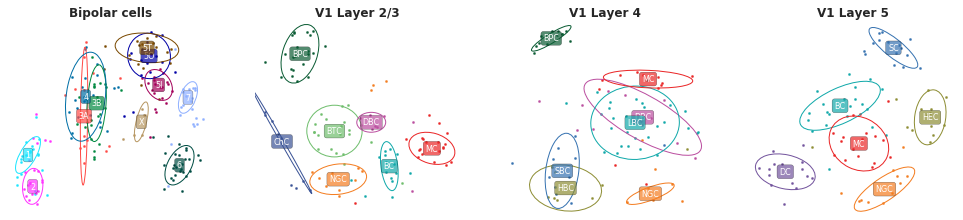

In [7]:
ellipses = True

sns.set_style('white')
plt.figure(figsize=(17,3.5))

for j, d in enumerate(datasets):    
    for i, file in enumerate(files):
        
        data = pd.read_csv('./data/embedding_data/'+file, header=[0,1,2], index_col=[0])
        X = data.values.T
        y = np.array(data.columns.get_level_values('type'))
        
        if d== 5:
            y[y == 'BC'] = 'LBC'
            y[y == 'SC'] = 'SBC'
            y[y == 'HEC'] = 'HBC'
        dataset = np.array(data.columns.get_level_values('ds_id')).astype(int)
    
        ind = (dataset==d) & ~np.isin(y, ['CBC8', 'CBC9', 'pyr'])
        
        Z = X[ind,:].copy()
        shape = Z.shape
        if file[:5]=='morph': 
            Z[Z==0] = 1
            Z.reshape(shape)
            transf = ~np.isin(morphFeatures, ['height', 'depth', 'median_tortuosity', 'max_tortuosity'])
            Z[:, transf] = np.log(Z[:, transf])
        
        Z = Z - Z.mean(axis=0)
        if file[:5]=='morph':        
            Z = Z / (Z.std(axis=0))

        U,s,V = np.linalg.svd(Z, full_matrices=False)
        Z = U @ np.diag(s)
        
        s_squared = s*s
        var_explained = s_squared/np.sum(s_squared)
        ix = np.where(np.cumsum(var_explained) > 0.9)[0][0]

        Z = Z[:,:ix]
        Z = Z / np.std(Z[:,0])
            
        if i==0:
            ZZ = Z.copy()
        else:
            ZZ = np.concatenate((ZZ,Z), axis=1)

    print(ZZ.shape)
    U,s,V = np.linalg.svd(ZZ, full_matrices=False)
    ZZ = U @ np.diag(s)
    ZZ = TSNE(perplexity=50, method='exact', random_state=42).fit_transform(ZZ)

    labels, yy = np.unique(y[ind], return_inverse=True)
    
    
    plt.subplot(1,len(datasets),j+1)
    for cl,l in enumerate(labels):
        if ellipses:
            c = clusterCols[l]
        else:
            c = 'k'
        plt.scatter(ZZ[yy==cl,0], ZZ[yy==cl,1],color=c, s=5)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])

    plt.title(datasetNames[j], weight='bold')

    # draw ellipses
    if ellipses:
        for cl,l in enumerate(labels):
            mcd = MinCovDet().fit(ZZ[yy==cl,:])
            mu = mcd.location_          
            Sigma = mcd.covariance_    

            val, vec = np.linalg.eigh(Sigma)
            width, height = 2 * np.sqrt(val[:, None] * r2)
            theta = np.degrees(np.arctan2(*vec[::-1, 0]))
            ellip = matplotlib.patches.Ellipse(xy=mu, width=width, height=height, angle=theta, 
                                               edgecolor=clusterCols[l], linewidth=1, facecolor='none')
            plt.gca().add_artist(ellip)        
            props = dict(boxstyle='round', facecolor=clusterCols[l], edgecolor=None, alpha=0.7)
            plt.text(mu[0], mu[1], labels[cl].replace("CBC","").replace("5X", "X"), 
                     color='white', fontsize=8, ha='center', va='center', bbox=props)
            
sns.despine(left=True, bottom=True)
